This notebook is for mapping out the Dovetrek checkpoints.

###Contents:
* [Imports](#Imports)
* [Start SparkSession](#Start-SparkSession)
* [Set Parameters](#set-params)
* [Get Secrets](#get-secrets)
* [Fetch Checkpoint Information](#fetch-cp-info)
* [Convert BNG to NGR](#bgn-to-ngr)
* [Convert NGR to Latitude/Logitude](#ngr-to-latlong)
* [Latitude/Longitude Bounding Box](#latlong-bbox)
* [NGR Bounding Box](#ngr-bbox)
* [Bing Maps plot Checkpoints](#bing-cp-map)
* [Ordnance Survey Map Plotting Calculations](#os-calcs)
  * [Get Checkpoint Pixel coordinates](#cp-pixel-coords)
  * [Add tilename and pixel coordinates to Openings_DF](#openings_df-coords)
  * [Fetch tiles and plot checkpoints](#get-tiles)
  * [Store canvas in memory](#canvas-to-memory)
  * [Save canvas back to filestore](#canvas-to-filestore)
* [Azure Maps](#azure-maps)

In [ ]:
pip install Pillow

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


### Imports <a class="anchor" id="imports"></a>

In [ ]:
from pyspark.sql.functions import udf, col, expr, first, max, min
from pyspark.sql import functions as F, DataFrame, Window, SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, FloatType, ArrayType, TimestampType
from datetime import datetime, time, timedelta
import requests
import time
import builtins
import json
import os
import ipywidgets
import base64
import getpass
import math
from IPython.display import Image
import itertools
from functools import reduce
import numpy as np
from io import BytesIO, StringIO
from PIL import Image as PILImage, ImageDraw, ImageFont

### Start SparkSession <a class="anchor" id="start-sparksession"></a>

In [ ]:
try:
    SparkSession.active()
except:
    spark = SparkSession.builder \
        .appName("BinderPySpark") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .getOrCreate()
else:
    SparkSession.active()
finally:
    # Test if Spark is working
    df = spark.createDataFrame([(1, "Alice"), (2, "Bob")], ["id", "name"])
    df.show()
    df.unpersist()

+---+-----+
| id| name|
+---+-----+
|  1|Alice|
|  2|  Bob|
+---+-----+



### Set Parameters <a class="anchor" id="set-params"></a>

In [ ]:
Year_List = ["2025", "2024", "2019", "2018", "2017"]
Map_Style_List = ["Outdoor_27700", "Leisure_27700", "Road_27700", "Light_27700"]

try:
    dbutils.widgets.dropdown("Competition Year", "2024", Year_List)
    # You can only pick 2017, 2018, 2019, 2024 & 2025 as we don't have the files for the others.
    Competition_Year = dbutils.widgets.get("Competition Year")

    dbutils.widgets.dropdown("MapStyle", "Outdoor_27700", Map_Style_List)
    MapStyle = dbutils.widgets.get("MapStyle")
    # per https://docs.os.uk/os-apis/accessing-os-apis/os-maps-api/layers-and-styles

    dbutils.widgets.dropdown("Zoom Level", "7", ["0","1","2","3","4","5","6","7","8","9"])
    zoom_level = int(dbutils.widgets.get("Zoom Level"))

except:
    Competition_Year_Picker = ipywidgets.Dropdown(options=Year_List, value = '2024', description = 'Pick a competition year:')
    Map_Style_Picker = ipywidgets.Dropdown(options=Map_Style_List, value = "Outdoor_27700", description = 'Pick an Ordnance Survey Map Style:')
    Zoom_Level_Picker = ipywidgets.IntSlider(value = 7
                                             , min = 0
                                             , max= 9
                                             , description = 'Pick a Zoom level'
                                             , readout = True
                                            , step = 1)
    display(Competition_Year_Picker)
    display(Map_Style_Picker)
    display(Zoom_Level_Picker)

    input("Fill and ctrl + enter when all parameters are set to the desired state")

    Competition_Year = Competition_Year_Picker.value
    MapStyle = Map_Style_Picker.value
    zoom_level = Zoom_Level_Picker.value



#dbutils.widgets.dropdown("API_Service", "Google Maps", ["Bing Maps","Google Maps", "OpenRouteService"])
#Mapping_Service = dbutils.widgets.get("API_Service")


### Get Secrets <a class="anchor" id="get-secrets"></a>

In [ ]:
GitHubPAT = getpass.getpass("Enter your GitHub Secrets Repo PAT: ")  # Prompt for PAT if not set

# 🔹 GitHub API URL to get the file
url = f"https://api.github.com/repos/liamj-f/Secrets/contents/Dovetrek_Secrets.json"

# 🔹 GitHub API headers
headers = {"Authorization": f"token {GitHubPAT}"}

# 🔹 Fetch the secrets file
response = requests.get(url, headers=headers)

if response.status_code == 200:
    # Decode Base64 content
    content = response.json()["content"]
    decoded_content = base64.b64decode(content).decode("utf-8")

    # Load JSON into a dictionary
    secrets = json.loads(decoded_content)

    # 🔹 Assign values to variables
    BingMapsAPIKey = secrets.get("BingMApsAPIKey", "")
    AzureMapsAPIKey = secrets.get("AzureMapsAPIKey", "")
    OrdnanceSurveyAPIKey = secrets.get("OrdnanceSurveyAPIKey", "")
    OpenRouteServiceAPIKey = secrets.get("OpenRouteServiceAPIKey", "")
    GoogleMapsAPIKey = secrets.get("GoogleMapsAPIKey", "")
    DovetrekRepoPAT = secrets.get("DovetrekRepoPAT", "")

    print("✅ Secrets loaded successfully!")

else:
    print(f"❌ Error: {response.status_code} - {response.text}")


Enter your GitHub Secrets Repo PAT:  [REDACTED]

✅ Secrets loaded successfully!


### Fetch Checkpoint information <a class="anchor" id="fetch-cp-info"></a>

In [ ]:
# GitHub API URL for file content
url = f"https://api.github.com/repos/liamj-f/Dovetrek/contents/CheckpointData/Openings_{Competition_Year}.csv"

# Fetch file content
response = requests.get(url)

content = response.json()["content"]
decoded_content = base64.b64decode(content).decode("utf-8")
csv_lines = decoded_content.split("\n")
# Create an RDD from the list
rdd = spark.sparkContext.parallelize(csv_lines)
# Convert RDD to DataFrame
openings_df = spark.read.csv(rdd, header=True, inferSchema=True)

### Convert BNG to NGR <a class="anchor" id="bng-to-ngr"></a>
The actual grid square identifiers are missing from the datasets because Dovetrek always takes place in the same area, so conversion from letter to number not necessary.

In [ ]:
openings_df = openings_df.withColumn("NGR_Easting", F.concat(F.lit("4"), F.substring(openings_df.BNG, 1, 3), F.lit("00")).cast("int")) \
                    .withColumn("NGR_Northing", F.concat(F.lit("3"), F.substring(openings_df.BNG, 5, 3), F.lit("00")).cast("int"))
display(openings_df)

CP BNG 1000 1030 1100 1130 1200 1230 1300 1330 1400 1430 1500 1530 1600 1630 1700 NGR_Easting NGR_Northing Start 258 779 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1.0 425800.0 377900.0 CP1 251 807 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1.0 425100.0 380700.0 CP2 265 801 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0.0 426500.0 380100.0 CP3 268 789 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1.0 426800.0 378900.0 CP4 262 747 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0.0 426200.0 374700.0 CP5 254 775 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0.0 425400.0 377500.0 CP6 251 786 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0.0 425100.0 378600.0 CP7 247 801 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1.0 424700.0 380100.0 E1 251 807 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0.0 425100.0 380700.0 E2R 274 814 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0.0 427400.0 381400.0 E3 234 807 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1.0 423400.0 380700.0 E4R 249 792 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0.0 424900.0 379200.0 E5 246 779 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0.0 424600.0 377900.0 E6 247 761 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0.0 424700.0 376100.0 E7U 263 758 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1.0 426300.0 375800.0 E8 245 745 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0.0 424500.0 374500.0 E9U 258 794 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1.0 425800.0 379400.0 E10U 252 817 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1.0 425200.0 381700.0 Finish 241 808 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1.0 424100.0 380800.0

### Convert NGR to Lat/Long <a class="anchor" id="NGR-to-LatLong"></a>

In [ ]:
LatLong_Df = spark.createDataFrame(
    [(1, 1.0, 1.0)],
    schema='CP string, Latitude float, Longitude float'
)
LatLong_Df = LatLong_Df.filter('1!=1')

# Convert DataFrame to a list
gridrefs_list = openings_df.select(
    openings_df.CP,
    openings_df.NGR_Easting,
    openings_df.NGR_Northing
).collect()

# Iterate over the list
for row in gridrefs_list:
    # Perform desired operations with the column values
    resp = requests.get(
        "http://webapps.bgs.ac.uk/data/webservices/CoordConvert_LL_BNG.cfc?method=BNGtoLatLng&easting="
        + str(row.NGR_Easting)
        + "&northing="
        + str(row.NGR_Northing)
    )

    # Parse the JSON response
    json_resp = json.loads(resp.text)

    # Check if 'LATITUDE' and 'LONGITUDE' keys exist in the response
    if 'LATITUDE' in json_resp and 'LONGITUDE' in json_resp:
        # Extract latitude and longitude values
        latitude = json_resp['LATITUDE']
        longitude = json_resp['LONGITUDE']
        cp = row["CP"]

        df = spark.createDataFrame(
            [(cp, latitude, longitude)],
            'CP string, Latitude float, Longitude float'
        )
        LatLong_Df = LatLong_Df.union(df)

openings_df = openings_df.join(LatLong_Df, openings_df.CP == LatLong_Df.CP).drop(LatLong_Df.CP)

LatLong_Df.unpersist()
# Show DataFrame
display(openings_df)

CP BNG 1000 1030 1100 1130 1200 1230 1300 1330 1400 1430 1500 1530 1600 1630 1700 NGR_Easting NGR_Northing Latitude Longitude CP1 251 807 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1.0 425100.0 380700.0 53.32263 -1.6246463 CP2 265 801 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0.0 426500.0 380100.0 53.317173 -1.6036792 CP3 268 789 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1.0 426800.0 378900.0 53.30637 -1.5992771 CP4 262 747 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0.0 426200.0 374700.0 53.26865 -1.6086259 CP5 254 775 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0.0 425400.0 377500.0 53.293858 -1.6203977 CP6 251 786 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0.0 425100.0 378600.0 53.303757 -1.6248118 CP7 247 801 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1.0 424700.0 380100.0 53.31726 -1.6306977 E1 251 807 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0.0 425100.0 380700.0 53.32263 -1.6246463 E10U 252 817 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1.0 425200.0 381700.0 53.331615 -1.623066 E2R 274 814 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0.0 427400.0 381400.0 53.32881 -1.5900581 E3 234 807 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1.0 423400.0 380700.0 53.322712 -1.6501671 E4R 249 792 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0.0 424900.0 379200.0 53.30916 -1.627766 E5 246 779 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0.0 424600.0 377900.0 53.29749 -1.6323686 E6 247 761 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0.0 424700.0 376100.0 53.281303 -1.6310076 E7U 263 758 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1.0 426300.0 375800.0 53.27853 -1.607036 E8 245 745 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0.0 424500.0 374500.0 53.266933 -1.6341299 E9U 258 794 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1.0 425800.0 379400.0 53.310913 -1.6142431 Finish 241 808 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1.0 424100.0 380800.0 53.323578 -1.6396511 Start 258 779 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1.0 425800.0 377900.0 53.297432 -1.6143645

### LatLong Bounding Box <a class="anchor" id="LatLong-bbox"></a>

In [ ]:
east, west, north, south = openings_df.agg(
    max(col("Longitude")).alias("East"),
    min(col("Longitude")).alias("West"),
    max(col("Latitude")).alias("North"),
    min(col("Latitude")).alias("South"),
).first()

north, east, south, west

(53.33161544799805,
 -1.5900580883026123,
 53.26693344116211,
 -1.6501671075820923)

### NGR Bounding Box <a class="anchor" id="ngr-bbox"></a>

In [ ]:
# Aggregate and pad Easting/Northing correctly
east, west, north, south = openings_df.agg(
    max(col("NGR_Easting")).cast("int").alias("East"),
    min(col("NGR_Easting")).cast("int").alias("West"),
    max(col("NGR_Northing")).cast("int").alias("North"),
    min(col("NGR_Northing")).cast("int").alias("South"),
).first()

# Collect bounding box values

north, east, south, west

(381700, 427400, 374500, 423400)

### Bing Maps plot Checkpoints <a class="anchor" id="bing-cp-map"></a>

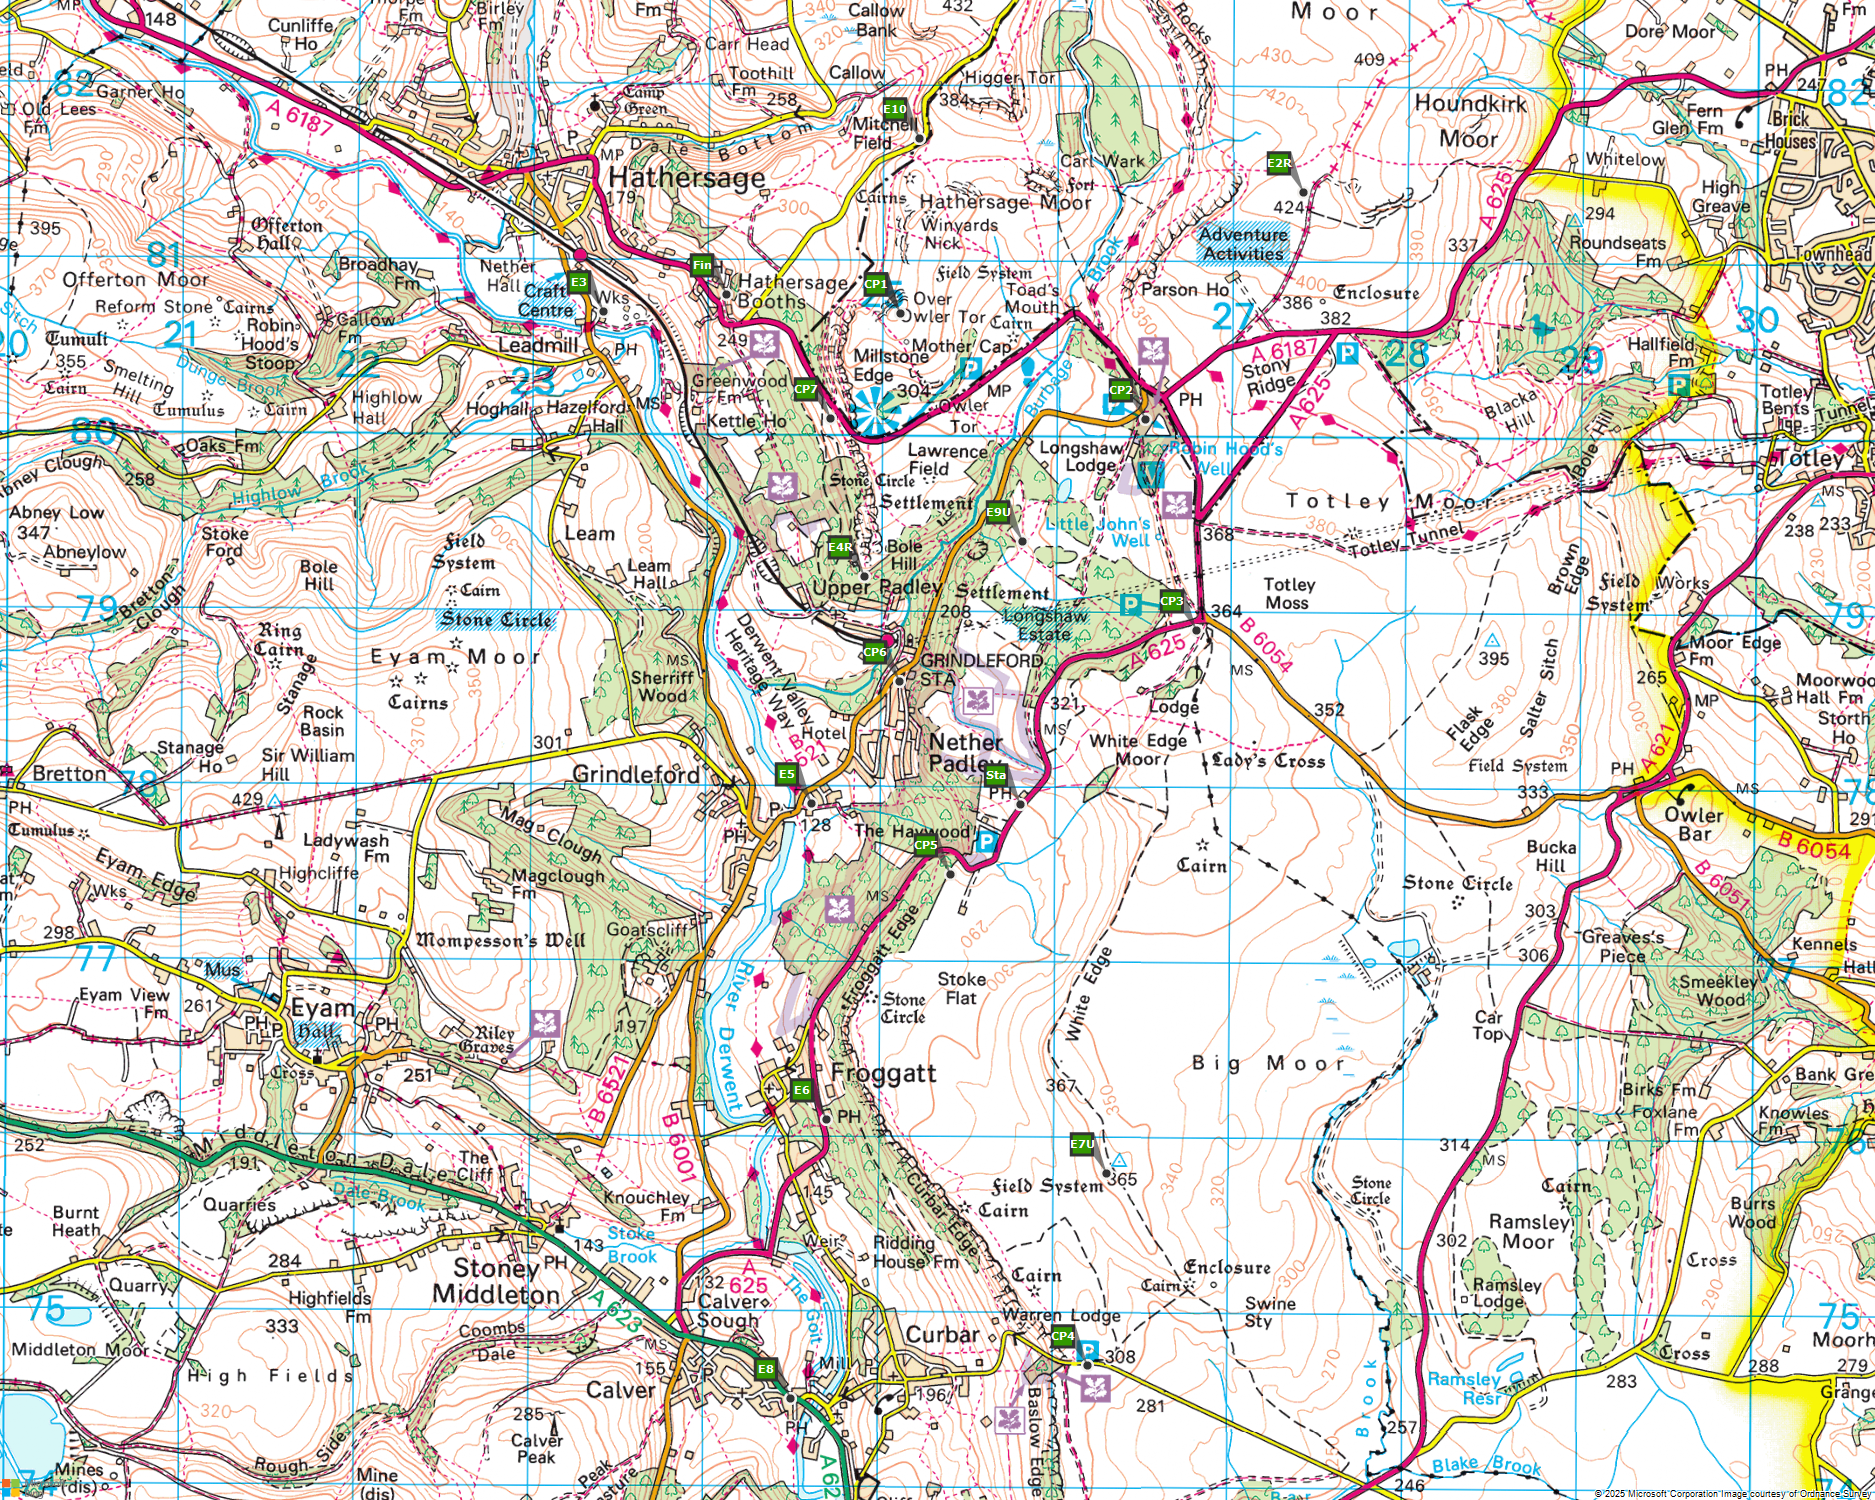

200

In [ ]:
url = "https://dev.virtualearth.net/REST/v1/Imagery/Map/Road"

# url = "https://dev.virtualearth.net/REST/v1/Imagery/Map/imagerySet?pushpin=53.369583,-1.6978767;;St&mapLAyer=OrdnanceSurvey&format=png&mapMetadata=0&key=" + BingMapsAPIKey

# https://dev.virtualearth.net/REST/v1/Imagery/Map/imagerySet?pushpin={pushpin_1}&pushpin={pushpin_2}&pushpin={pushpin_n}&mapLayer={mapLayer}&format={format}&mapMetadata={mapMetadata}&key={BingMapsKey}

url_params = {
    "mapLayer": "OrdnanceSurvey",
    "format": "png",
    "mapMetadata": 0,
    "declutterPins": 0,
    "mapSize": "2000, 1600",
 #   "mapArea": f"{north_east},{south_west}",
    "key": BingMapsAPIKey
}

req_body = "&".join([f"pp={row['Latitude']},{row['Longitude']};35;{row['CP'][:3]}" for row in openings_df.collect()])
req_body_bytes = req_body.encode('utf-8')

req_headers = {
    "content-type": "text/plain",
    "charset": "utf-8",
    "Content-Length":str(len(req_body_bytes))
}

resp = requests.post(url, headers=req_headers, params=url_params, data=req_body)

display(Image(resp.content))
resp.status_code


### Azure Maps Plot Checkpoints

In [ ]:
# Construct properly formatted markers
markers = []
for row in openings_df.collect():
    lat, lon, name = row["Latitude"], row["Longitude"], row["CP"]
    markers.append(f"'{name}'{lon} {lat}")  # Longitude first!

pins = "default|ls15|sc1.5||" + "|".join(markers)

# Construct the API URL
params = {
    "subscription-key": AzureMapsAPIKey,
    "api-version": "1.0",
    "TilesetId": "microsoft.imagery",
    "zoom": 15,
    "bbox": LLBBox,
    "pins": pins
}

# Make API request
response = requests.get("https://atlas.microsoft.com/map/static/png", params=params)

# Check if request was successful
if response.status_code == 200:
    display(Image(response.content))
else:
    print("Error fetching map:", response.text)


## Ordnance Survey Map Plotting Calculations <a class="anchor" id="OS-calcs"></a>
### NGR to Tiles <a class="anchor" id="ngr-to-tiles"></a>

In [ ]:
# Constants
# https://github.com/OrdnanceSurvey/tile-name-derivation is the font of knowledge

TILE_SIZE = 256  # Pixels per tile
ORIGIN_X = -238375.0  # False origin X
ORIGIN_Y = 1376256.0  # False origin Y

# Define scale per zoom level (meters per pixel)
ZOOM_RESOLUTIONS = {
    0: 896,
    1: 448,
    2: 224,
    3: 112,
    4: 56,
    5: 28,
    6: 14,
    7: 7,
    8: 3.5,
    9: 1.75,
    10: 0.875,
    11: 0.4375,
    12: 0.21875,
    13: 0.109375
}

def ngr_to_tile(easting, northing, zoom):
    """Convert BNG easting/northing to OS tile x, y at a given zoom level using false origin."""
    resolution = ZOOM_RESOLUTIONS.get(zoom, 896)  # Default to zoom 0 if not found
    # Calculate tile meters
    tile_meters = TILE_SIZE * (896 / (2 ** zoom))
    # Convert to tile coordinates
    tile_x = math.floor((easting - ORIGIN_X) / tile_meters)
    tile_y = math.floor((ORIGIN_Y - northing) / tile_meters)
    print(f"Zoom: {zoom}, Resolution: {resolution}m per pixel, Tile meters: {tile_meters}m")
    print(f"Easting: {easting}, Northing: {northing} -> Tile X: {tile_x}, Tile Y: {tile_y}")
    return tile_x, tile_y

# Convert bounding box to tile coordinates
x_min, y_min = ngr_to_tile(west, north, zoom_level)  # Top-left tile
x_max, y_max = ngr_to_tile(east, south, zoom_level)  # Bottom-right tile

# Generate all tile coordinates in range
tiles = [(zoom_level, x, y) for x in range(x_min, x_max + 1) for y in range(y_min, y_max + 1)]

# Print the tile coordinates
print(f"Total Tiles: {len(tiles)}")
for tile in tiles:
    print(tile)  # (zoom, x, y)

Zoom: 8, Resolution: 3.5m per pixel, Tile meters: 896.0m
Easting: 423400, Northing: 381700 -> Tile X: 738, Tile Y: 1109
Zoom: 8, Resolution: 3.5m per pixel, Tile meters: 896.0m
Easting: 427400, Northing: 374500 -> Tile X: 743, Tile Y: 1118
Total Tiles: 60
(8, 738, 1109)
(8, 738, 1110)
(8, 738, 1111)
(8, 738, 1112)
(8, 738, 1113)
(8, 738, 1114)
(8, 738, 1115)
(8, 738, 1116)
(8, 738, 1117)
(8, 738, 1118)
(8, 739, 1109)
(8, 739, 1110)
(8, 739, 1111)
(8, 739, 1112)
(8, 739, 1113)
(8, 739, 1114)
(8, 739, 1115)
(8, 739, 1116)
(8, 739, 1117)
(8, 739, 1118)
(8, 740, 1109)
(8, 740, 1110)
(8, 740, 1111)
(8, 740, 1112)
(8, 740, 1113)
(8, 740, 1114)
(8, 740, 1115)
(8, 740, 1116)
(8, 740, 1117)
(8, 740, 1118)
(8, 741, 1109)
(8, 741, 1110)
(8, 741, 1111)
(8, 741, 1112)
(8, 741, 1113)
(8, 741, 1114)
(8, 741, 1115)
(8, 741, 1116)
(8, 741, 1117)
(8, 741, 1118)
(8, 742, 1109)
(8, 742, 1110)
(8, 742, 1111)
(8, 742, 1112)
(8, 742, 1113)
(8, 742, 1114)
(8, 742, 1115)
(8, 742, 1116)
(8, 742, 1117)
(8, 742, 

### Get Checkpoint Pixel coordinates <a class="anchor" id="cp-pixel-coords"></a>

In [ ]:
def get_pixel_coords(easting, northing, zoom=zoom_level):
    tileMeters = TILE_SIZE * (896 / (2 ** zoom))  # Tile size in meters

    # Compute tile column and row
    tile_x = math.floor((easting - ORIGIN_X) / tileMeters)
    tile_y = math.floor((ORIGIN_Y - northing) / tileMeters)

    # Compute tile top-left corner
    tile_top_left_easting = ORIGIN_X + (tile_x * tileMeters)
    tile_top_left_northing = ORIGIN_Y - (tile_y * tileMeters)

    # Compute pixel coordinates within the tile
    pixel_x = (easting - tile_top_left_easting) / (tileMeters / 256)
    pixel_y = (tile_top_left_northing - northing) / (tileMeters / 256)

    return f"{pixel_x:.2f}, {pixel_y:.2f}"


### Add tilename and pixel coordinates to Openings_DF <a class="anchor" id="openings_df-coords"></a>

In [ ]:
# Define UDF to format the tilename
def get_tilename(easting, northing, zoom=zoom_level):
    tile_x, tile_y = ngr_to_tile(easting, northing, zoom)
    return f"{zoom}/{tile_x}/{tile_y}"

# Register UDF
tile_name_udf = udf(get_tilename, StringType())
pixel_coords_udf = udf(get_pixel_coords, StringType())

openings_df = openings_df.withColumn("tilename", tile_name_udf(openings_df["NGR_Easting"], openings_df["NGR_Northing"]))
openings_df = openings_df.withColumn("pixel_coords", pixel_coords_udf(openings_df["NGR_Easting"], openings_df["NGR_Northing"]))

# Show result
display(openings_df)

CP BNG 1000 1030 1100 1130 1200 1230 1300 1330 1400 1430 1500 1530 1600 1630 1700 NGR_Easting NGR_Northing Latitude Longitude tilename pixel_coords CP1 251 807 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1.0 425100.0 380700.0 53.32263 -1.6246463 8/740/1111 124.29, 28.57 CP2 265 801 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0.0 426500.0 380100.0 53.317173 -1.6036792 8/742/1111 12.29, 200.00 CP3 268 789 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1.0 426800.0 378900.0 53.30637 -1.5992771 8/742/1113 98.00, 30.86 CP4 262 747 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0.0 426200.0 374700.0 53.26865 -1.6086259 8/741/1117 182.57, 206.86 CP5 254 775 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0.0 425400.0 377500.0 53.293858 -1.6203977 8/740/1114 210.00, 174.86 CP6 251 786 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0.0 425100.0 378600.0 53.303757 -1.6248118 8/740/1113 124.29, 116.57 CP7 247 801 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1.0 424700.0 380100.0 53.31726 -1.6306977 8/740/1111 10.00, 200.00 E1 251 807 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0.0 425100.0 380700.0 53.32263 -1.6246463 8/740/1111 124.29, 28.57 E10U 252 817 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1.0 425200.0 381700.0 53.331615 -1.623066 8/740/1109 152.86, 254.86 E2R 274 814 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0.0 427400.0 381400.0 53.32881 -1.5900581 8/743/1110 13.43, 84.57 E3 234 807 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1.0 423400.0 380700.0 53.322712 -1.6501671 8/738/1111 150.57, 28.57 E4R 249 792 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0.0 424900.0 379200.0 53.30916 -1.627766 8/740/1112 67.14, 201.14 E5 246 779 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0.0 424600.0 377900.0 53.29749 -1.6323686 8/739/1114 237.43, 60.57 E6 247 761 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0.0 424700.0 376100.0 53.281303 -1.6310076 8/740/1116 10.00, 62.86 E7U 263 758 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1.0 426300.0 375800.0 53.27853 -1.607036 8/741/1116 211.14, 148.57 E8 245 745 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0.0 424500.0 374500.0 53.266933 -1.6341299 8/739/1118 208.86, 8.00 E9U 258 794 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1.0 425800.0 379400.0 53.310913 -1.6142431 8/741/1112 68.29, 144.00 Finish 241 808 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1.0 424100.0 380800.0 53.323578 -1.6396511 8/739/1111 94.57, 0.00 Start 258 779 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1.0 425800.0 377900.0 53.297432 -1.6143645 8/741/1114 68.29, 60.57

###Fetch tiles and plot checkpoints <a class="anchor" id="get-tiles"></a>

In [ ]:
# Font settings (adjust as needed)
try:
    font = ImageFont.truetype("arial.ttf", (zoom_level*2))  # Try loading Arial
except IOError:
    font = ImageFont.load_default()  # Fallback if Arial is not available

# Marker settings
marker_radius = zoom_level  # Radius of the checkpoint circle
marker_color = (255, 0, 0)  # Red color for marker
text_color = (0, 0, 0)  # Black text for labels

# Initialize the canvas
canvas_width = (x_max - x_min + 1) * TILE_SIZE
canvas_height = (y_max - y_min + 1) * TILE_SIZE
canvas = PILImage.new('RGB', (canvas_width, canvas_height), (255, 255, 255))

# Store processed tiles before stitching
tile_images = {}

# Loop through all tiles and download them
for zoom, x, y in tiles:
    tile_url = f"https://api.os.uk/maps/raster/v1/zxy/{MapStyle}/{zoom}/{x}/{y}.png?key={OrdnanceSurveyAPIKey}"
    response = requests.get(tile_url)

    if response.status_code == 200:
        tile_img = PILImage.open(BytesIO(response.content))
        draw = ImageDraw.Draw(tile_img)

        # Find checkpoints that belong to this tile
        checkpoints_in_tile = openings_df.filter(
            (openings_df["tilename"] == f"{zoom}/{x}/{y}")
        ).collect()

        for checkpoint in checkpoints_in_tile:
            pixel_x, pixel_y = map(float, checkpoint["pixel_coords"].split(", "))
            name = checkpoint["CP"]  # Assuming column exists

            # Draw marker
            draw.ellipse(
                (pixel_x - marker_radius, pixel_y - marker_radius,
                 pixel_x + marker_radius, pixel_y + marker_radius),
                fill=marker_color
            )

            # Add text label
            draw.text((pixel_x + 8, pixel_y - 8), name, fill=text_color, font=font)

        # Store the modified tile
        tile_images[(x, y)] = tile_img

        print(f"Downloaded and processed tile: {tile_url}")
    else:
        print(f"Failed to download tile: {tile_url} - Status Code {response.status_code}")

# Stitch tiles onto the canvas
for (x, y), tile_img in tile_images.items():
    tile_x = (x - x_min) * TILE_SIZE
    tile_y = (y - y_min) * TILE_SIZE
    canvas.paste(tile_img, (tile_x, tile_y))

### Store Canvas in memory <a class="anchor" id="canvas-to-memory"></a>

In [ ]:
# 🔹 Save image to an in-memory buffer
buf = BytesIO()
canvas.save(buf, format="PNG")  # Save as PNG in memory
buf.seek(0)  # Move to start of buffer

# 🔹 Convert buffer to Base64
encoded_content = base64.b64encode(buf.read()).decode("utf-8")

filename = F"{Competition_Year}_OrdnanceSurvey_{MapStyle}_{zoom_level}_{datetime.today().date()}.png"

### Save canvas back to filestore <a class="anchor" id="save-to-filestore"></a>

In [ ]:
# 🔹 GitHub API URL
url = f"https://api.github.com/repos/liamj-f/Dovetrek/contents/Maps/{filename}"

# Get the latest SHA (if the file exists)
response = requests.get(url, headers={"Authorization": f"token {DovetrekRepoPAT}"})
sha = response.json().get("sha") if response.status_code == 200 else None

# 🔹 Upload file to GitHub
payload = {
    "message": "Auto-upload {filename} from memory",
    "content": encoded_content,
    "branch": "FileStore"
}
if sha:
    payload["sha"] = sha  # Required if updating an existing file

response = requests.put(url, headers={"Authorization": f"token {DovetrekRepoPAT}"}, json=payload)

if response.status_code in [200, 201]:
    print(f"✅ {filepath} uploaded successfully to Dovetrek/Maps (Filestore branch)!")
else:
    print(f"❌ Error: {response.status_code} - {response.text}")


✅ Maps/2025_OrdnanceSurvey_Leisure_27700_8_2025-02-22.png uploaded successfully to Dovetrek/Filestore!


## Azure Maps

In [ ]:
bounding_box = '-1.8136975,53.34539,-1.6905249,53.38501'
url = "https://atlas.microsoft.com/map/static/png"

# url = "https://dev.virtualearth.net/REST/v1/Imagery/Map/imagerySet?pushpin=53.369583,-1.6978767;;St&mapLAyer=OrdnanceSurvey&format=png&mapMetadata=0&key=" + BingMapsAPIKey

# https://dev.virtualearth.net/REST/v1/Imagery/Map/imagerySet?pushpin={pushpin_1}&pushpin={pushpin_2}&pushpin={pushpin_n}&mapLayer={mapLayer}&format={format}&mapMetadata={mapMetadata}&key={BingMapsKey}

map_params = {
    'api-version': '1.0',
    'layer': 'basic',
    'tilesetid': 'microsoft.base.road',
    'style': 'main',
    'zoom': 15,
    'bbox':  bounding_box,  # Replace with your desired coordinates
    'subscription-key': AzureMapsAPIKey
}

response = requests.get(url, params=map_params)

display(Image(response.content))

